##### This is a script that train a set of 3D-Unet models on a downsampled HCP 7T resting state fMRI dataset after preprocessing. Ray.Tune is used for model selection

Unet implementation is borrowed from Adrian Wolney on https://github.com/wolny/pytorch-3dunet 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import json

import torch as t
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
# 3D-UNet model imported here, path need to be included
from pytorch3dunet.unet3d import model

from dataset_management import LS_dataset_subj, LS_dataset_subjSave
from utils_LS.Unet_LS_trainers import train_loop, val_loop, train_and_eval, take_a_look, test_set_recon_n_save, test_metrics
from utils_LS.experiment_load import load_experiment_results

from ray import tune, air
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

t_seed = t.manual_seed(2112)
n_seed = random.seed(0)
np_seed = np.random.seed(0)

device = t.device("cuda" if t.cuda.is_available() else "cpu")
dtype_pt = t.float32
print(device)

TRAIN_INPUT_PATH = 'E:/Master_Project_Marius/Processed_HCP_data/Training_data/LS_imgs'
TRAIN_LABEL_PATH = 'E:/Master_Project_Marius/Processed_HCP_data/Training_data/Original_HCP'

TEST_INPUT_PATH = 'E:/Master_Project_Marius/Processed_HCP_data/Testing_data/LS_imgs'
TEST_LABEL_PATH = 'E:/Master_Project_Marius/Processed_HCP_data/Testing_data/Original_HCP'

EXPERIMENT_PATH = 'C:/Users/MariusER/Documents/GitHub/Master-Project-LoopingStar/DL_training_py/3D-Unet/raytune_results/model_select_Unet'

EPOCHS = 20

cuda


### 1. Defining datasets

In [2]:
total_data = LS_dataset_subj(TRAIN_LABEL_PATH, TRAIN_INPUT_PATH)

Datasets = random_split(total_data, [0.9397, 0.0603], generator=t.Generator().manual_seed(2112))

train_set = DataLoader(Datasets[0], batch_size=4, shuffle=True, num_workers=2)
val_set = DataLoader(Datasets[1], batch_size=1, shuffle=False, num_workers=2)

### 2. Defining necessary elements for model selection:
- Tuner function
- Model
- Loss function
- Optimizer
- Parameter space
- Scheduler
- Search algorithm

In [3]:
EPOCHS = 20

def model_select(config):
    t.manual_seed(2112)
    Unet3D = model.UNet3D(in_channels=1, out_channels=1, num_groups=config['gn_size'], is_segmentation=False)
    Unet3D.load_state_dict(t.load('C:/Users/MariusER/Documents/GitHub/Master-Project-LoopingStar/DL_training_py/3D-Unet/Unet3D_trained_optim.pt'))
    Unet3D.to(device=device, dtype=dtype_pt)

    optimizer = t.optim.Adam(Unet3D.parameters(), lr=config['lr_rate'], weight_decay=config['weight_decay'], amsgrad=True)

    loss_fn = nn.MSELoss()

    for epoch in range(1, EPOCHS +1):

        loss_train = train_loop(epoch,train_set, Unet3D, optimizer, loss_fn, device, num_augment=2, num_vol=5)

        loss_val, hist_out = val_loop(epoch, val_set, Unet3D, loss_fn, device, num_augment=2)

        tune.report(val_loss = loss_val, train_loss = loss_train, hist_val = hist_out)

search_space = {
    'gn_size' : tune.choice([2, 4, 8]),
    'lr_rate' : tune.loguniform(1e-6, 1e-4),
    'weight_decay' : tune.uniform(0., 1e-3)
    }

HBforBOHB_scheduler = HyperBandForBOHB('training_iteration', metric='val_loss', mode='min', max_t=EPOCHS)

BOHB_searcher = TuneBOHB(metric='val_loss', mode='min',  max_concurrent=1)  

trainable_with_cpu_gpu = tune.with_resources(model_select, {"cpu": 8, "gpu": 1})

tuner = tune.Tuner(
        trainable_with_cpu_gpu,
        tune_config=tune.TuneConfig(
            num_samples = 6,
            search_alg = BOHB_searcher,
            scheduler = HBforBOHB_scheduler
            ),
        param_space = search_space,
        run_config=air.RunConfig(local_dir="./raytune_results", name="model_select_Unet")
    )

results = tuner.fit()



2023-03-04 18:38:17,843	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hist_val,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train_loss,training_iteration,trial_id,val_loss,warmup_time
model_select_7f8c6b09,2023-03-04_20-37-43,False,,5800972571e74a22baeefd39568ea84b,[ -inf 5252.604 9413.719 15007.395 21092.873 16887.926 14872.835 14117.922 13582.428 13158.724 12867.066 12668.891 12545.104 12504.507 12482.332 12539.24 12783.35 13653.727 15141.354 16223.754 16563.83 16426.03 16145.3 15786.376 15403.226 15003.3955 14529.526 13974.6045 13376.657 12776.092 12200.091 11660.585 11168.227 10709.889 10292.204 9909.194 9552.632 9218.433 8895.854 8553.317 8211.449 7856.8545 7500.145 7107.968 6711.301 6310.28 5872.6973 5424.6694 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf],DESKTOP-7ADNTS6,2,127.0.0.1,5888,7160,3038.49,7160,1677958663,0,,3.12949,2,7f8c6b09,2.62022,0.00398874


(model_select pid=5888) 2023-03-05 05:44:46,030	INFO trainable.py:791 -- Restored on 127.0.0.1 from checkpoint: c:\Users\MariusER\Documents\GitHub\Master-Project-LoopingStar\DL_training_py\3D-Unet\raytune_results\model_select_Unet\model_select_7f8c6b09_1_gn_size=8,lr_rate=0.0000,weight_decay=0.0005_2023-03-04_18-38-19\checkpoint_tmp553ef2
(model_select pid=5888) 2023-03-05 05:44:46,030	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 7159.999377965927, '_episodes_total': 0}
(model_select pid=5888) 2023-03-05 10:48:52,325	INFO trainable.py:791 -- Restored on 127.0.0.1 from checkpoint: c:\Users\MariusER\Documents\GitHub\Master-Project-LoopingStar\DL_training_py\3D-Unet\raytune_results\model_select_Unet\model_select_d2f4eb1f_2_gn_size=4,lr_rate=0.0000,weight_decay=0.0003_2023-03-04_20-37-44\checkpoint_tmpcbe7a4
(model_select pid=5888) 2023-03-05 10:48:52,325	INFO trainable.py:800 -- Current state after restoring: {'_iteration'

### 3. Evaluating result

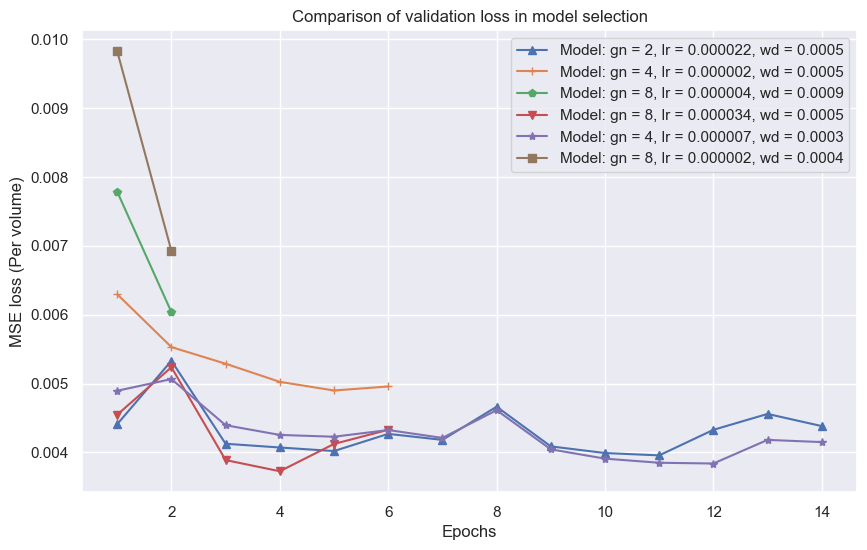

In [13]:

import seaborn as sns
sns.set()

results_load = load_experiment_results(EXPERIMENT_PATH, 6, 'result.json')

plt.figure(figsize=(10,6))
plt.plot(results_load[0]['iteration'][2:], [this_loss/(10*50) for this_loss in results_load[0]['val_loss'][2:]], '-^',
              label='Model: gn = {}, lr = {:.6f}, wd = {:.4f}'.format(results_load[0]['config']['gn_size'], results_load[0]['config']['lr_rate'], results_load[0]['config']['weight_decay']))
plt.plot(results_load[1]['iteration'][2:], [this_loss/(10*50) for this_loss in results_load[1]['val_loss'][2:]], '-+',
              label='Model: gn = {}, lr = {:.6f}, wd = {:.4f}'.format(results_load[1]['config']['gn_size'], results_load[1]['config']['lr_rate'], results_load[1]['config']['weight_decay']))
plt.plot(results_load[2]['iteration'][0:], [this_loss/(10*50) for this_loss in results_load[2]['val_loss'][0:]], '-p',
              label='Model: gn = {}, lr = {:.6f}, wd = {:.4f}'.format(results_load[2]['config']['gn_size'], results_load[2]['config']['lr_rate'], results_load[2]['config']['weight_decay']))
plt.plot(results_load[3]['iteration'][2:], [this_loss/(10*50) for this_loss in results_load[3]['val_loss'][2:]], '-v',
              label='Model: gn = {}, lr = {:.6f}, wd = {:.4f}'.format(results_load[3]['config']['gn_size'], results_load[3]['config']['lr_rate'], results_load[3]['config']['weight_decay']))
plt.plot(results_load[4]['iteration'][8:], [this_loss/(10*50) for this_loss in results_load[4]['val_loss'][8:]], '-*',
              label='Model: gn = {}, lr = {:.6f}, wd = {:.4f}'.format(results_load[4]['config']['gn_size'], results_load[4]['config']['lr_rate'], results_load[4]['config']['weight_decay']))
plt.plot(results_load[5]['iteration'][0:], [this_loss/(10*50) for this_loss in results_load[5]['val_loss'][0:]], '-s',
              label='Model: gn = {}, lr = {:.6f}, wd = {:.4f}'.format(results_load[5]['config']['gn_size'], results_load[5]['config']['lr_rate'], results_load[5]['config']['weight_decay']))

plt.xlabel("Epochs")
plt.locator_params(axis="x", integer=True, tight=True)
plt.ylabel("MSE loss (Per volume)")
plt.title("Comparison of validation loss in model selection")
plt.legend()
plt.show()

In [5]:
best_result = results.get_best_result(metric='val_loss', mode='min')
print(f"The best model achieved a loss of {best_result.metrics['val_loss']}")
print(f"with the parameters learning rate: {best_result.config['lr_rate']} weight decay: {best_result.config['weight_decay']} and group_norm size: {best_result.config['gn_size']}")

The best model achieved a loss of 2.075113369093742
with the parameters learning rate: 6.846324719699346e-06 weight decay: 0.0002887411275646763 and group_norm size: 4


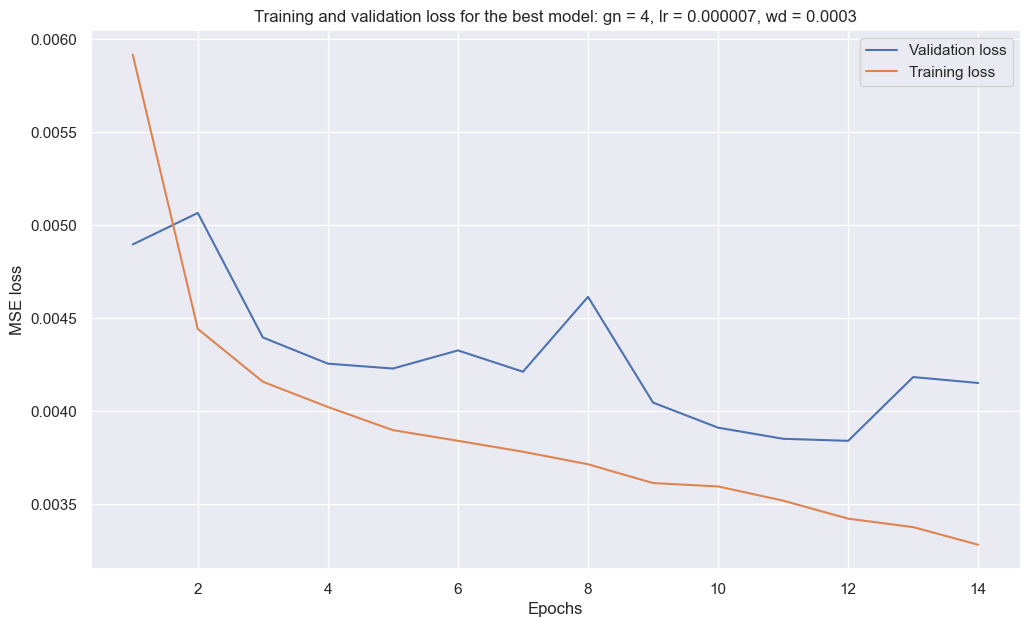

In [6]:

plt.figure(figsize=(12,7))
plt.plot(results_load[4]['iteration'][8:], [this_loss/(10*50) for this_loss in results_load[4]['val_loss'][8:]], label='Validation loss')
plt.plot(results_load[4]['iteration'][8:], [this_loss/(156*5) for this_loss in results_load[4]['train_loss'][8:]], label='Training loss')


plt.xlabel("Epochs")
plt.locator_params(axis="x", integer=True, tight=True)
plt.ylabel("MSE loss")
plt.title('Training and validation loss for the best model: gn = {}, lr = {:.6f}, wd = {:.4f}'.format(results_load[4]['config']['gn_size'], results_load[4]['config']['lr_rate'], results_load[4]['config']['weight_decay']))
plt.legend()
plt.show()

### 4. Training model based on the best model hyperparameters

Training time: 99 hours 3 min

In [5]:
t.manual_seed(2112)

best_hparams = results_load[4]['config']

Unet3D = model.UNet3D(in_channels=1, out_channels=1, num_groups=best_hparams['gn_size'], is_segmentation=False)
Unet3D.load_state_dict(t.load('C:/Users/MariusER/Documents/GitHub/Master-Project-LoopingStar/DL_training_py/3D-Unet/Unet3D_trained_optim.pt'))
Unet3D.to(device=device, dtype=dtype_pt)

optimizer = t.optim.Adam(Unet3D.parameters(), lr=best_hparams['lr_rate'], weight_decay=best_hparams['weight_decay'], amsgrad=True)

loss_fn = nn.MSELoss()

train_loss, val_loss, val_hists = train_and_eval(
                                EPOCHS, 
                                train_set, 
                                val_set, 
                                Unet3D, 
                                optimizer, 
                                loss_fn,
                                device,
                                num_augment=2,
                                model_savename='Unet3D_raytuned_optim.pt')



Validating Epoch 20: 100%|████████████████████████████████████████| 10/10 [08:08<00:00, 48.87s/batch, loss=1.9] 


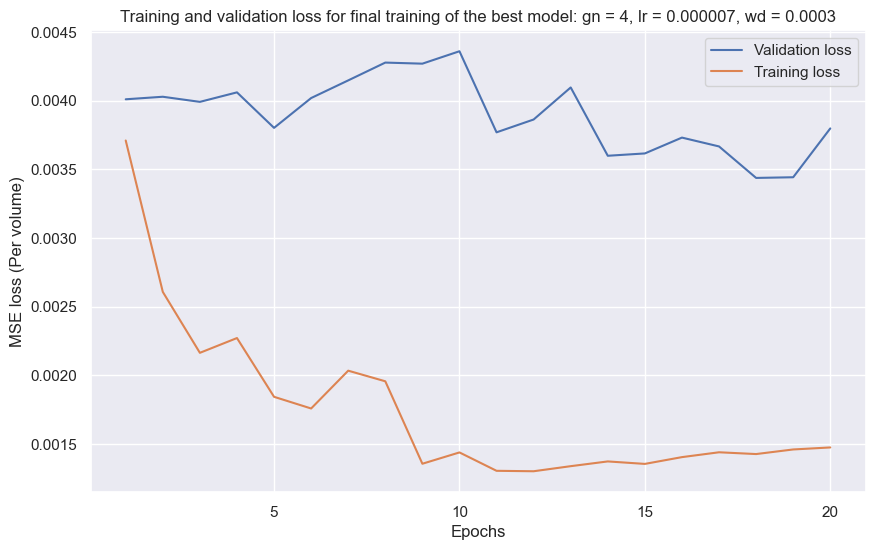

In [7]:

with open('train_metrics_tuned.json') as json_file:
            train_metrics = json.loads(json_file.read())

x_ax = range(1, EPOCHS+1)

plt.figure(figsize=(10,6))
plt.plot(x_ax, [this_loss/(10*50) for this_loss in train_metrics["val_loss"]], label='Validation loss')
plt.plot(x_ax, [this_loss/(156*50) for this_loss in train_metrics["train_loss"]], label='Training loss')


plt.xlabel("Epochs")
plt.locator_params(axis="x", integer=True, tight=True)
plt.ylabel("MSE loss (Per volume)")
plt.title('Training and validation loss for final training of the best model: gn = {}, lr = {:.6f}, wd = {:.4f}'.format(results_load[4]['config']['gn_size'], results_load[4]['config']['lr_rate'], results_load[4]['config']['weight_decay']))
plt.legend()
plt.show()

### 5. Taking a quick look

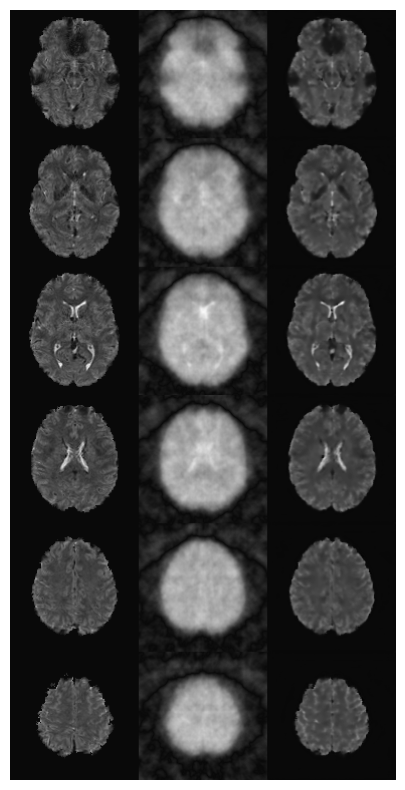

In [3]:

results_load = load_experiment_results(EXPERIMENT_PATH, 6, 'result.json')

best_hparams = results_load[4]['config']

Unet3D = model.UNet3D(in_channels=1, out_channels=1, num_groups=best_hparams['gn_size'], is_segmentation=False)
Unet3D.load_state_dict(t.load('C:/Users/MariusER/Documents/GitHub/Master-Project-LoopingStar/DL_training_py/3D-Unet/Unet3D_raytuned_optim.pt'))

take_a_look(Unet3D, val_set, device, subindex = 1)

### 6. DL-recon and saving of test set

In [7]:
SAVEPATH = 'E:/Master_Project_Marius/Processed_HCP_data/Testing_data/Unet_recon_3D/RayTuned'

total_data_test = LS_dataset_subjSave(TEST_INPUT_PATH)
test_set = DataLoader(total_data_test, batch_size=1, shuffle=False)

test_set_recon_n_save(Unet3D, test_set, device, SAVEPATH)

Subject 654552: 100%|██████████| 900/900 [04:43<00:00,  3.17volume/s]
